In [1]:
import pandas as pd 
import statsmodels.api as sm 
import numpy as np 
from statsmodels.stats.weightstats import ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import plotly.express as px 
plt.style.use('ggplot')

In [2]:
# initialize data
data = pd.read_csv('../data/hospitalisations.csv')
df = data
df.columns = ['date', 'intensive','in-care']
df['total'] = df['intensive'] + df['in-care']
df['date'] = pd.to_datetime(df['date'])

In [3]:
# define period of interest
start_date = '2020-08-02'
end_date = '2020-09-29'
open_date = '2020-08-31'
period = df.loc[(df['date'] > start_date) & (df['date'] < end_date)]
period.reset_index(drop=True, inplace=True)

In [4]:
fig = px.line(period, x = 'date', y = [period.total,period.intensive,period['in-care']],
              title='Hospitalization cases during period (August 3rd to Sept 28th)')
fig.show()

In [5]:
import statsmodels.formula.api as smf
# setting with copy warning
period['time'] = period.index
period['school'] = (period['date'] > open_date).astype(int)
period['time2'] = period.time ** 2

x = sm.add_constant(period)
est = smf.wls('total ~ school * time2', x).fit()
# y = const + b1 * x + b2 * c
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                  total   R-squared:                       0.794
Model:                            WLS   Adj. R-squared:                  0.783
Method:                 Least Squares   F-statistic:                     68.21
Date:                Wed, 27 Jan 2021   Prob (F-statistic):           3.35e-18
Time:                        14:31:32   Log-Likelihood:                -167.20
No. Observations:                  57   AIC:                             342.4
Df Residuals:                      53   BIC:                             350.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        8.4609      1.300      6.510      0.000       5.854      11.068
school          -9.0872      2.888     -3.147      0.003     -14.879      -3.295
time2           -0.0011      0.004     -0.300      0.765      -0.008       0.006
school:time2     0.0131      0.004      3.405      0.001       0.005       0.021
==============================================================================
Omnibus:                        7.570   Durbin-Watson:                   2.073
Prob(Omnibus):                  0.023   Jarque-Bera (JB):                8.595
Skew:                           0.507   Prob(JB):                       0.0136
Kurtosis:                       4.609   Cond. No.                     9.40e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.4e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [6]:
period.head()

,date,intensive,in-care,total,time,school,time2
0,2020-08-03,11,1,12,0,0,0
1,2020-08-04,4,1,5,1,0,1
2,2020-08-05,6,0,6,2,0,4
3,2020-08-06,9,1,10,3,0,9
4,2020-08-07,13,3,16,4,0,16


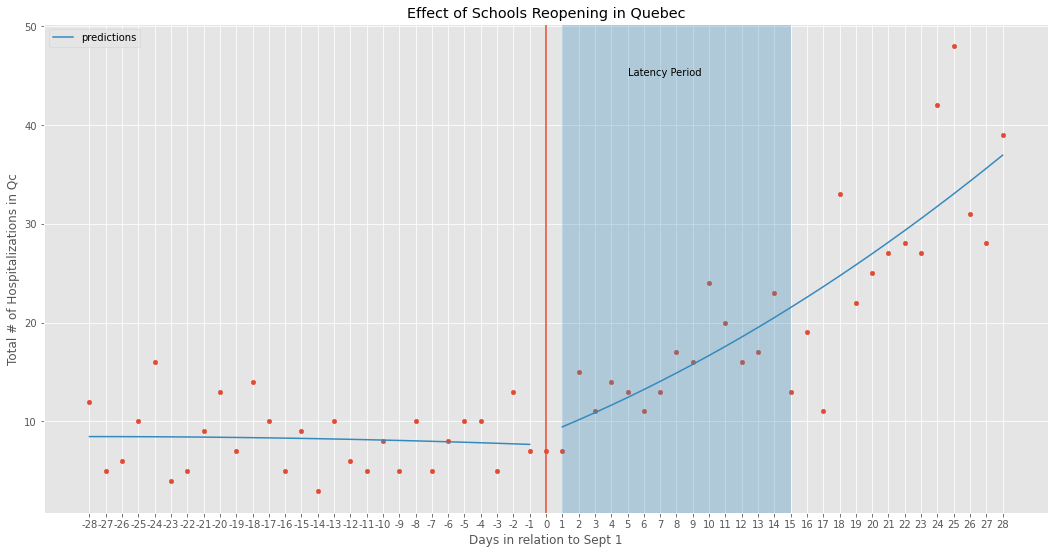

In [7]:
# plotting using a slightly hacked fix to an ongoing issue
ax = period.plot.scatter(x="time", y="total", color="C0")
period = period.assign(predictions=est.fittedvalues) 
# setting the prediction value to nan for discontinuity visualization
period.iat[28, 7] = np.nan
period.plot(x="time", y="predictions", ax=ax, color="C1", figsize=(18,9))
plt.axvspan(xmin=29, xmax=43, ymin=0, ymax=1, alpha=0.3)
plt.title("Effect of Schools Reopening in Quebec");
plt.axvline(x=28, ymin=0, ymax=48)
plt.xlabel('Days in relation to Sept 1')
plt.ylabel('Total # of Hospitalizations in Qc')
plt.annotate('Latency Period', (33,45))
# Changing ticks
nticks = list(range(-28,29,1))
plt.xticks(period.time, nticks);
# period.tail()

## Analysis

#### Amount of time before cutoff: 
Four weeks, given the clarity of the data I felt able to extend as far as four weeks to demonstrate the strength of the argument.

#### Polynomial used: 
Squared

#### Other regression design considerations:
Hospitalization total is a combined statistic which accumulates cases where patients are hospitalized within and outside of intensive care.
'Time' was used instead of an actual datetime for the ease of implementation and the data was incremented into days already.

### Explanation of findings:
The findings suggest a powerful relationship between the opening of schools and the number of hospitalizations attributed to Covid-19, as demonstrated by the discontinuity plot.

Of note in the findings is the speed at which the hospitaliazations increased. Labelled on the plot as 'Latency Period' is the 14 days immediately after the reopening of schools.
Given my current understanding of the nature of Covid-19 I had anticipated a less immediate response to schools reopening.

It's possible that this suggests some secondary contributing facot